In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd "/content/gdrive/MyDrive/pytorch-AdaIN"

Mounted at /content/gdrive
/content/gdrive/MyDrive/pytorch-AdaIN


In [2]:
import cv2
import numpy as np
import torch
from PIL import Image

from net import vgg, decoder
from function import adaptive_instance_normalization, coral

In [3]:
class StyleTransfer:

  def __init__(self):
    
    vgg_enc = vgg
    vgg_dec = decoder
    vgg_enc.load_state_dict(torch.load("models/vgg_normalised.pth"))
    vgg_dec.load_state_dict(torch.load("models/decoder.pth"))

    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.vgg_enc = vgg_enc[:31].to(self.device)
    self.vgg_dec = vgg_dec.to(self.device)
    
    self.vgg_enc.eval()
    self.vgg_dec.eval()

  def run(self, content_img, style_img, alpha=1.0, preserve_color=True):

    content_img = torch.FloatTensor(content_img).permute(2,0,1)
    style_img = torch.FloatTensor(style_img).permute(2,0,1)

    if preserve_color:
      style_img = coral(style_img, content_img)
    
    content_img = content_img.unsqueeze(0).to(self.device)
    style_img = style_img.unsqueeze(0).to(self.device)

    with torch.no_grad():
      content_feat = self.vgg_enc(content_img)
      style_feat = self.vgg_enc(style_img)
      new_feat = adaptive_instance_normalization(content_feat, style_feat)
      new_feat = alpha*new_feat + (1-alpha)*content_feat
      new_img = self.vgg_dec(new_feat)
    
    return new_img.squeeze(0).cpu()


def show_img(img):
  
  img = img.permute(1,2,0).numpy()
  img = 255*(img-img.max()) / (img.max()-img.min())
  img = Image.fromarray(img.astype("uint8"))
  display(img)

In [4]:
# Style Tenasfer 모델 생성
model = StyleTransfer()

In [5]:
# 이미지 불러오기
content_img = cv2.imread("input/content/chicago.jpg")
style_img = cv2.imread("input/style/sketch.png")

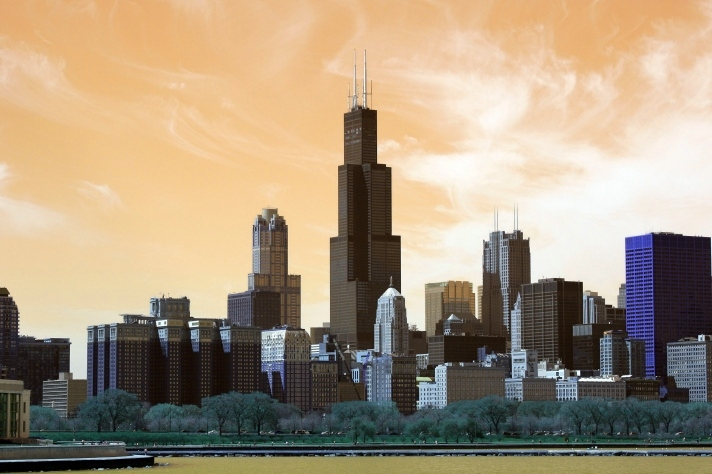

In [6]:
# Content 이미지
display(Image.fromarray(content_img))

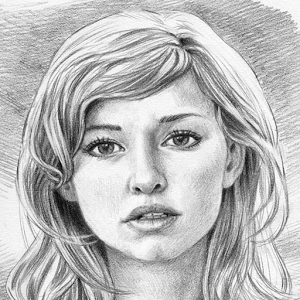

In [7]:
# Style 이미지
display(Image.fromarray(style_img))

In [8]:
# Style Transfer
new_img = model.run(content_img, style_img, alpha=1)    # alpha: 0~1 사이 값, 0에 가까울 수록 content 이미지에 집중

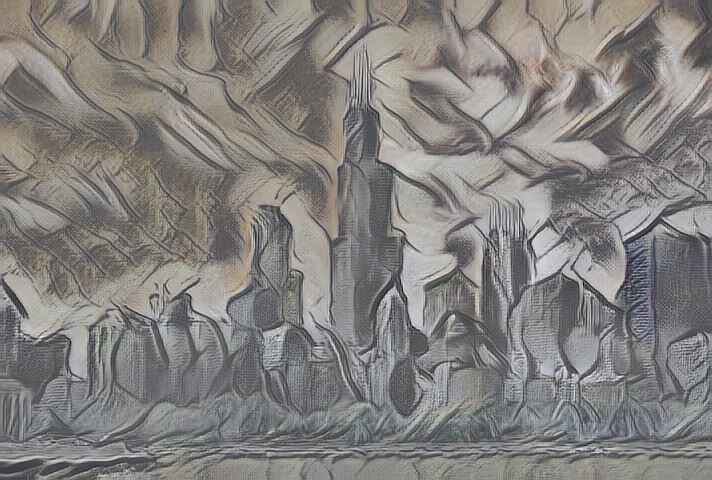

In [9]:
# Style Transfer된 이미지
show_img(new_img)